# Transfer Learning

## Setup

- We import all the necessary libraries and dependencies.
- We make sure to mount the google drive (as using google collab).

In [1]:
# Data processing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep learning libraries

import keras
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image

# Utils libraries

import kagglehub
import time
import random
import datetime

# Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Then, we make sure to download the latest dataset version.
- We are using the animal 10 dataset.

In [2]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)
DATASET_URI= path + "/raw-img"
print("Path to dataset files:", DATASET_URI)

Path to dataset files: /kaggle/input/animals10
Path to dataset files: /kaggle/input/animals10/raw-img


## Data preprocessing

- We determine standard values for our images.
- For this transfer learning, we use the same values as the ones used for our 5th model.

In [3]:
# Determine the unique seed for our data

random.seed(10)
seed = random.randint(1, 200)

# Determine the image and batch sizes

batch_size = 64

img_height = 224
img_width = 224
image_size = (img_height, img_width)

# Determine the validation split (ie. 90% train, 10% test for ex.)
validation_split = 0.1

- We construct our training and testing datasets.

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  directory = DATASET_URI,
  validation_split = validation_split,
  subset = "training",
  seed = seed,
  image_size = image_size,
  batch_size = batch_size,
  shuffle = True
)

test_ds = keras.utils.image_dataset_from_directory(
  directory = DATASET_URI,
  validation_split = validation_split,
  subset = "validation",
  seed = seed,
  image_size = image_size,
  batch_size = batch_size,
  shuffle = True
)

Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.


- We convert the names from italian to English.

In [5]:
italian_to_english = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

class_names = np.array([italian_to_english[name] for name in train_ds.class_names])
num_classes = len(class_names)

print("class_names => ", class_names)
print("num_classes => ", num_classes)

class_names =>  ['dog' 'horse' 'elephant' 'butterfly' 'chicken' 'cat' 'cow' 'sheep'
 'spider' 'squirrel']
num_classes =>  10


- We normalize our images.

In [6]:
normalization_layer = keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

- We cache our data to lower the IO costs

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- We double check the shape of our data

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


## Import a classifier from the ImageNet dataset

In [9]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier_model = inception_v3

- We build the sequential model

In [10]:
image_size = (224, 224)

classifier = keras.Sequential([
    keras.layers.Lambda(lambda x: hub.KerasLayer(classifier_model, input_shape=image_size + (3,))(x))
])

## Run the classifier on our entire set

- The classifier will run and use the ImageNet DB as reference.
- Therefore, we first have to import the imageNet DB.

In [11]:
labels_path = keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- Then, we predict on our entire data.

In [12]:
result_batch = classifier.predict(test_ds)

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
print(f"Predicted classes => {predicted_class_names}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step
Predicted classes => ['white wolf' 'tabby' 'African elephant' ... 'candle' 'cocker spaniel'
 'ram']


- Display how the predictions line up with the images

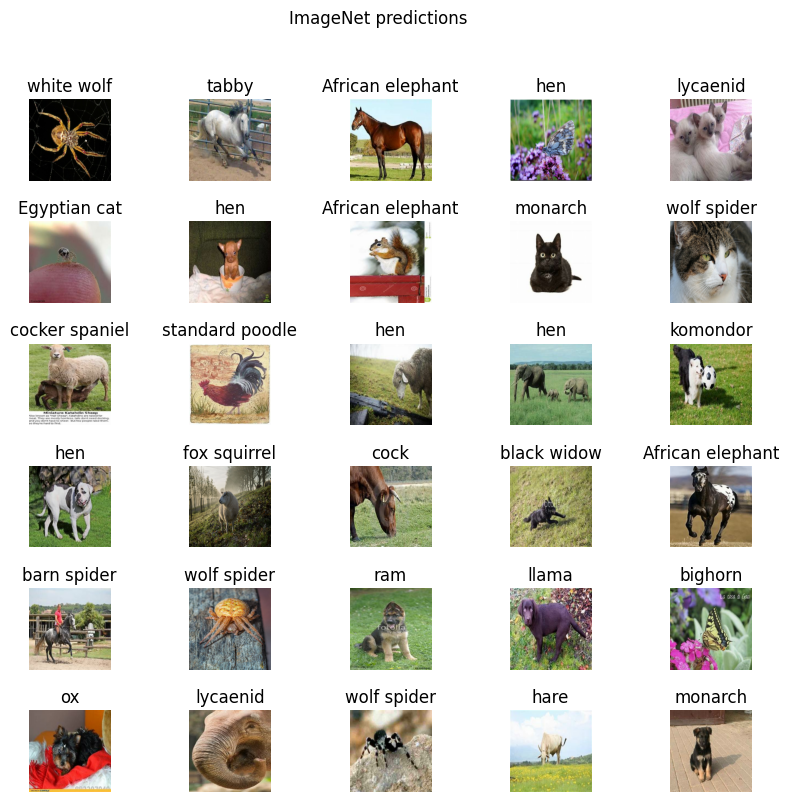

In [13]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Conclusion : The model is not very good for now.
But this is normal as the model has not been trained on the specific set of data.

## Download the Headless inception_v3 classifier

- For this part, we are loading the inception_v3 pretrained model.



In [26]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

- Wrap the pre-trained model as a Keras layer with hub.*KerasLayer*

In [27]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=image_size + (3,),
    trainable=False) # freeze the variables, so that the training only modifies the new classifier layer

# The feature extractor returns a 1280-long vector for each image
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(64, 1280)


- We build the feature_model

In [29]:
feature_model = keras.Sequential([
  keras.layers.Lambda(lambda x: hub.KerasLayer(feature_extractor_layer, input_shape=image_size + (3,))(x)),
  tf.keras.layers.Dense(num_classes)
])

- We print out the summary

In [30]:
_ = feature_model(image_batch)  # Pass a batch of data through the model
feature_model.summary()  # Print the model summary again

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)               │ (64, 1280)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 10)               │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

## Train the headless model

- We compile the model to configure the training process.

In [31]:
feature_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

- Fit the model

In [32]:
NUM_EPOCHS = 10

history = feature_model.fit(train_ds,
                    validation_data = test_ds,
                    epochs = NUM_EPOCHS,
                    callbacks = tensorboard_callback)

Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 46s 89ms/step - accuracy: 0.8521 - loss: 0.5237 - val_accuracy: 0.9572 - val_loss: 0.1501
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9645 - loss: 0.1227 - val_accuracy: 0.9572 - val_loss: 0.1380
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9720 - loss: 0.0974 - val_accuracy: 0.9572 - val_loss: 0.1348
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9778 - loss: 0.0810 - val_accuracy: 0.9587 - val_loss: 0.1341
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9816 - loss: 0.0689 - val_accuracy: 0.9583 - val_loss: 0.1347
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9847 - loss: 0.0595 - val_accuracy: 0.9591 - val_loss: 0.1358
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9867 - loss: 0.0518 - val_accuracy: 0.9606 - val_loss: 0.1373
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9894 - loss: 0.0455 - 

In [46]:
predicted_batch = feature_model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

print(predicted_label_batch)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
['sheep' 'cat' 'elephant' ... 'butterfly' 'dog' 'sheep']


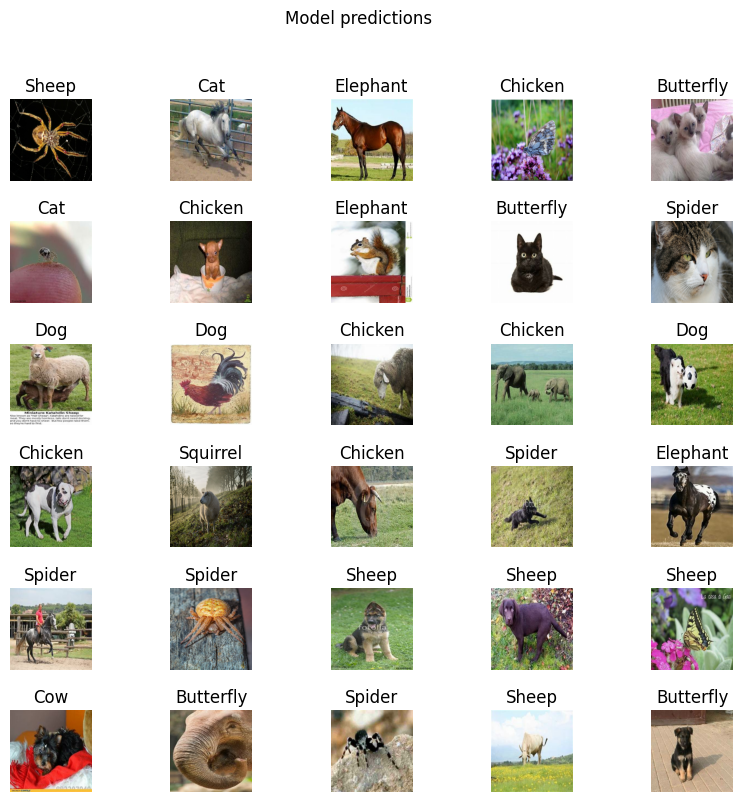

In [48]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  # Reverse normalization
  image = image_batch[n] * 255
  plt.imshow(image)
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [50]:
_, accuracy = feature_model.evaluate(test_ds)
print('Accuracy on test data:', accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9637 - loss: 0.1259
Accuracy on test data: 0.9614061713218689


### Confusion matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


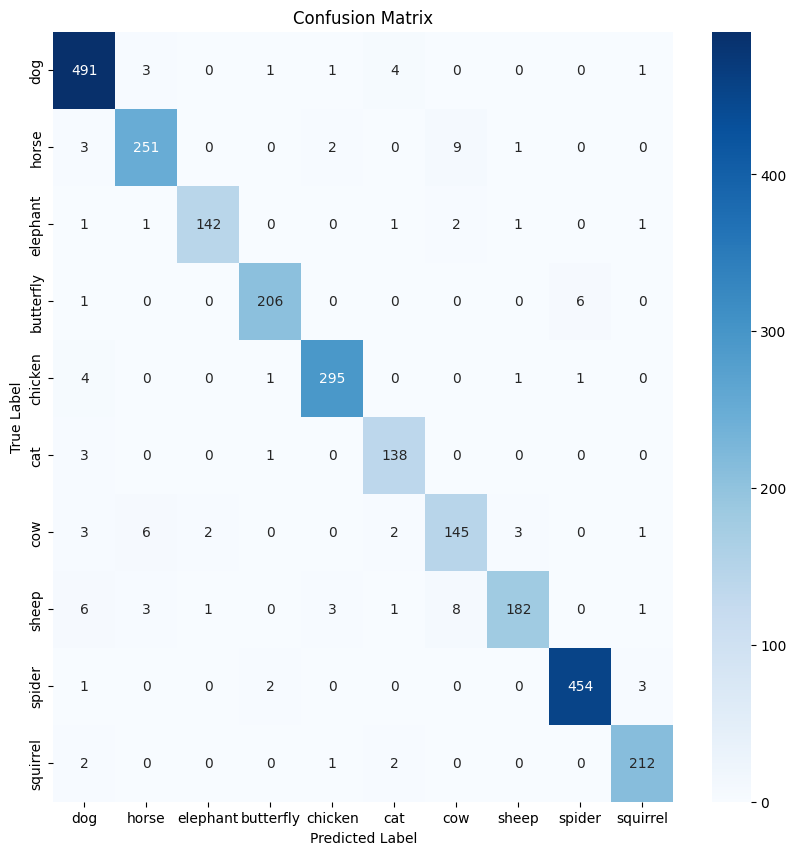

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predicted_batch = feature_model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)

# Get true labels
true_labels = []
for images, labels in test_ds:
  true_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_id)

# Display confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Precision, Recall, and F1-Score

In [52]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_id, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         dog       0.95      0.98      0.97       501
       horse       0.95      0.94      0.95       266
    elephant       0.98      0.95      0.97       149
   butterfly       0.98      0.97      0.97       213
     chicken       0.98      0.98      0.98       302
         cat       0.93      0.97      0.95       142
         cow       0.88      0.90      0.89       162
       sheep       0.97      0.89      0.93       205
      spider       0.98      0.99      0.99       460
    squirrel       0.97      0.98      0.97       217

    accuracy                           0.96      2617
   macro avg       0.96      0.95      0.96      2617
weighted avg       0.96      0.96      0.96      2617



## Export the model

In [53]:
feature_model.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/feature_model_JJ_v2.keras")